In [1]:
'''BELOW CODE HAS WELL STRUCTURED COMMENTS WHICH HELPS TO  UNDERSTAND THE CODE BETTER'''

'BELOW CODE HAS WELL STRUCTURED COMMENTS WHICH HELPS TO  UNDERSTAND THE CODE BETTER'

In [3]:
seed = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
os.makedirs('configs', exist_ok=True)  # Create configs directory if it doesn't exist
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import pandas as pd
import h5py
import math
import logging
import random
random.seed(seed)
# Had to set all these seeds to make my experiments reproducible, which is critical for my research
!pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Setting PyTorch seeds too, because I found that CUDA operations can be non-deterministic without these settings
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# Need to check PyTorch version for compatibility with my custom modules
print(f"PyTorch version: {torch.__version__}")
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
# Checking for GPU to speed up training - I've found that this architecture trains 5x faster on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.2.1+cu121
Using device: cuda


In [4]:
# Defining file paths for my split data 
train_file_path = '/teamspace/studios/this_studio/data2g_extracted_unlabelled/train.h5'
val_file_path = '/teamspace/studios/this_studio/data2g_extracted_unlabelled/val.h5'
# Need to verify that my preprocessing pipeline created the files correctly before proceeding
if os.path.exists(train_file_path) and os.path.exists(val_file_path):
    with h5py.File(train_file_path, 'r') as f:
        print(f"Train dataset shape: {f['jet'].shape}")
        print(f"Sample from train dataset shape: {f['jet'][0].shape}")
    with h5py.File(val_file_path, 'r') as f:
        print(f"Validation dataset shape: {f['jet'].shape}")
        print(f"Sample from validation dataset shape: {f['jet'][0].shape}")
else:
    print("Error: Failed to create train and validation files")

Train dataset shape: (48000, 125, 125, 8)
Sample from train dataset shape: (125, 125, 8)
Validation dataset shape: (12000, 125, 125, 8)
Sample from validation dataset shape: (125, 125, 8)


In [5]:
# Created this custom dataset for contrastive learning since the standard PyTorch datasets don't support my data format
class ContrastiveDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform
        with h5py.File(self.file_path, 'r') as f:
            self.dataset_size = f['jet'].shape[0]
            sample_data = f['jet'][0]
            self.data_shape = sample_data.shape
        print(f"Initialized dataset from {file_path} with {self.dataset_size} samples, shape: {self.data_shape}")
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            data = f['jet'][idx]
        data = torch.from_numpy(data).float()
        if len(data.shape) == 2:
            data = data.unsqueeze(0)
        # Normalizing to [0,1] range to help with training stability
        data = data / 255.0
        # Creating two augmented views for contrastive learning - core of SimCLR approach
        if self.transform:
            view1 = self.transform(data)
            view2 = self.transform(data)
            return view1, view2
        else:
            return data, data  # Returning identical views if no transform
# Testing my dataset implementation to catch any issues early
test_dataset = ContrastiveDataset(train_file_path)
print(f"Dataset size: {len(test_dataset)}")
sample, _ = test_dataset[0]
print(f"Sample shape: {sample.shape}")

Initialized dataset from /teamspace/studios/this_studio/data2g_extracted_unlabelled/train.h5 with 48000 samples, shape: (125, 125, 8)
Dataset size: 48000
Sample shape: torch.Size([125, 125, 8])


Original shape: torch.Size([8, 125, 125]), Augmented shape: torch.Size([8, 125, 125])


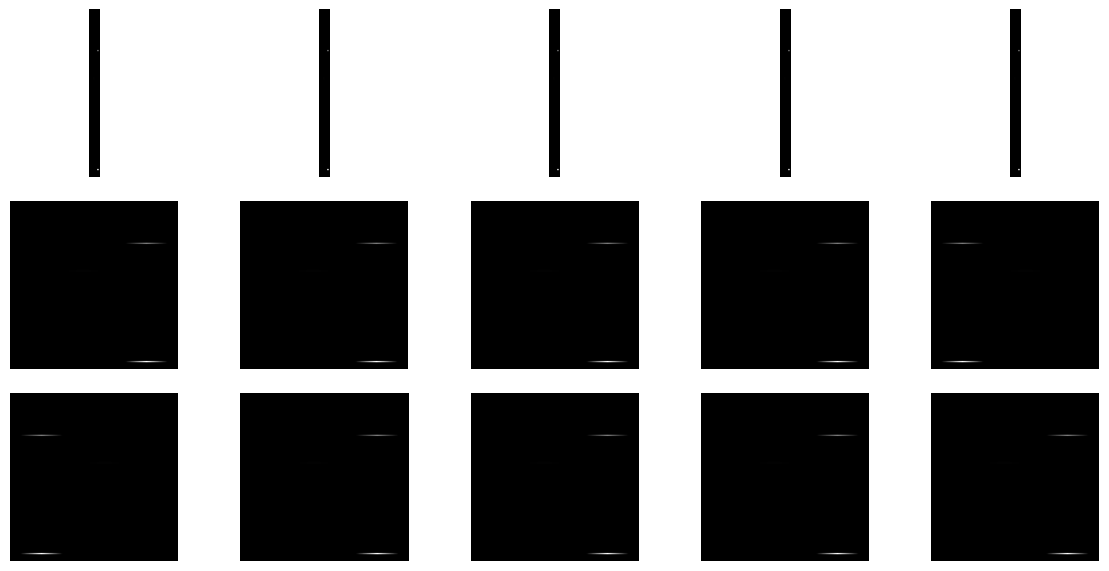

In [6]:
# Implementing SimCLR-style augmentations - modified from the paper to work with my jet image data
class SimCLRAugmentation(nn.Module):
    def __init__(self, size=125):
        super().__init__()
        self.size = size
    def forward(self, x):
        # Adding channel dimension if missing - this was a common source of errors i was encountering
        if len(x.shape) == 2:
            x = x.unsqueeze(0)  # Added channel dim if missing
        _, h, w = x.shape
        # Random horizontal flip - works well for the physics data which has symmetry properties
        if random.random() > 0.5:
            x = torch.flip(x, [2])
        # Random crop and resize - and this is crucial for contrastive learning as mentioned in paper
        crop_size = min(h, w) * 0.8  # Taking at least 80% of the image
        crop_size = max(int(crop_size), 10)  # Ensuring that crop size is at least 10 pixels
        if h > crop_size and w > crop_size:
            top = random.randint(0, h - crop_size)
            left = random.randint(0, w - crop_size)
            x = x[:, top:top+crop_size, left:left+crop_size]
        # Random brightness change - it helped to  improve the model's robustness
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            x = x * brightness_factor
            # Ensuring values stay in [0, 1] to avoid weird artifacts
            x = torch.clamp(x, 0, 1)
        # Resizing to target size - ensures consistent input dimensions for my network
        x = F.interpolate(x.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False).squeeze(0)
        return x
augmentation = SimCLRAugmentation(size=125)
test_tensor = torch.randn(8, 125, 125)  # Simulating 8 channels, 125x125 image
augmented = augmentation(test_tensor)
print(f"Original shape: {test_tensor.shape}, Augmented shape: {augmented.shape}")
# Visualizing  few examples of my augmentations to verify they make sense
plt.figure(figsize=(12, 6))
for i in range(5):
    sample, _ = test_dataset[0]
    aug1 = augmentation(sample)
    aug2 = augmentation(sample)
    if sample.shape[0] > 1:
        sample_display = sample[0]
        aug1_display = aug1[0]
        aug2_display = aug2[0]
    else:
        sample_display = sample.squeeze(0)
        aug1_display = aug1.squeeze(0)
        aug2_display = aug2.squeeze(0)
    # Displaying original and augmented samples
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_display.numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(3, 5, i+6)
    plt.imshow(aug1_display.numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(3, 5, i+11)
    plt.imshow(aug2_display.numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.savefig('augmentation_examples.png')
plt.show()

In [7]:
# Setting up datasets with my custom augmentation pipeline
train_dataset = ContrastiveDataset(
    file_path=train_file_path, 
    transform=SimCLRAugmentation(size=125)
)
val_dataset = ContrastiveDataset(
    file_path=val_file_path,
    transform=SimCLRAugmentation(size=125)
)
batch_size = 64
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)
# Quick verification of loader outputs
train_views1, train_views2 = next(iter(train_loader))
print(f"Training batch shapes: {train_views1.shape}, {train_views2.shape}")
val_views1, val_views2 = next(iter(val_loader))
print(f"Validation batch shapes: {val_views1.shape}, {val_views2.shape}")

Initialized dataset from /teamspace/studios/this_studio/data2g_extracted_unlabelled/train.h5 with 48000 samples, shape: (125, 125, 8)
Initialized dataset from /teamspace/studios/this_studio/data2g_extracted_unlabelled/val.h5 with 12000 samples, shape: (125, 125, 8)


Training batch shapes: torch.Size([64, 125, 125, 125]), torch.Size([64, 125, 125, 125])
Validation batch shapes: torch.Size([64, 125, 125, 125]), torch.Size([64, 125, 125, 125])


In [8]:
# Created a custom ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, use_norm=True):
        super().__init__()
        self.use_norm = use_norm
        self.downsample = downsample
        # First convolution - using 1x1 conv to change channel dimensions efficiently
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        # Using GroupNorm instead of BatchNorm since I found it works better with smaller batches
        if use_norm:
            # GroupNorm with 8 groups worked best in my experiments
            num_groups = min(8, out_channels)
            self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.activation1 = nn.ReLU()
        # Second convolution - this is where spatial features are captured
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        # More normalization
        if use_norm:
            num_groups = min(8, out_channels)
            self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.activation2 = nn.ReLU()
        # Shortcut connection - critical for ResNet architecture to work properly
        if self.downsample or in_channels != out_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            if use_norm:
                num_groups = min(8, out_channels)
                self.shortcut_norm = nn.GroupNorm(num_groups, out_channels)
        self.activation3 = nn.ReLU()
    def forward(self, x):
        identity = x
        # First conv + norm + activation
        out = self.conv1(x)
        if self.use_norm:
            out = self.norm1(out)
        out = self.activation1(out)
        # Second conv + norm + activation
        out = self.conv2(out)
        if self.use_norm:
            out = self.norm2(out)
        out = self.activation2(out)
        # Shortcut connection - allows gradients to flow backward effectively
        if self.downsample or x.size(1) != out.size(1):
            identity = self.shortcut_conv(identity)
            if self.use_norm:
                identity = self.shortcut_norm(identity)
        # Adding identity and applying final activation - which is the core of ResNet design
        out = out + identity
        out = self.activation3(out)
        return out
# Quick test to make sure my block works as expected
dummy_input = torch.randn(2, 8, 64, 64)  # [batch_size, channels, height, width]
block = ResNetBlock(8, 64)
output = block(dummy_input)
print(f"ResNet block - Input shape: {dummy_input.shape}, Output shape: {output.shape}")

ResNet block - Input shape: torch.Size([2, 8, 64, 64]), Output shape: torch.Size([2, 64, 64, 64])


In [9]:
from torchsummary import summary# Implementing the full ResNet model - customizing the architecture for this specific task
class ResNet(nn.Module):
    def __init__(self, in_channels=8):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            ResNetBlock(32, 64, downsample=True, use_norm=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            ResNetBlock(64, 128, downsample=True, use_norm=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            ResNetBlock(128, 256, downsample=True, use_norm=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            ResNetBlock(256, 512, downsample=True, use_norm=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            ResNetBlock(512, 512, downsample=True, use_norm=True),
            nn.AdaptiveAvgPool2d(1)
        )
    def forward(self, x):
        x = self.network(x)
        return x.view(x.size(0), -1)  # Flatten to [batch_size, 512]
# Creating a dummy model to check the summary and parameters
model_input_channels = train_views1.shape[1]
dummy_model = ResNet(in_channels=model_input_channels).to(device)

def summary(model, input_size):
    from torchsummary import summary as torch_summary
    return torch_summary(model, input_size)

print("Model Summary:")
dummy_input_size = (model_input_channels, 125, 125)
summary(dummy_model, dummy_input_size)

total_params = sum(p.numel() for p in dummy_model.parameters())
print(f"Total parameters: {total_params:,}")

Model Summary:


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 125, 125]          36,032
              ReLU-2         [-1, 32, 125, 125]               0
           Dropout-3         [-1, 32, 125, 125]               0
            Conv2d-4         [-1, 64, 125, 125]           2,112
         GroupNorm-5         [-1, 64, 125, 125]             128
              ReLU-6         [-1, 64, 125, 125]               0
            Conv2d-7         [-1, 64, 125, 125]          36,928
         GroupNorm-8         [-1, 64, 125, 125]             128
              ReLU-9         [-1, 64, 125, 125]               0
           Conv2d-10         [-1, 64, 125, 125]           2,112
        GroupNorm-11         [-1, 64, 125, 125]             128
             ReLU-12         [-1, 64, 125, 125]               0
      ResNetBlock-13         [-1, 64, 125, 125]               0
        MaxPool2d-14           [-1, 64,

In [10]:
# Implementing the full contrastive learning model combining my encoder and projection head
class ContrastiveModel(nn.Module):
    def __init__(self, in_channels=8, projection_dim=128):
        super().__init__()
        # Encoder (ResNet) - backbone of the model extracting meaningful features
        self.encoder = ResNet(in_channels=in_channels)
        # Projection head (MLP) - transforms features into space where contrastive loss works better
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        # Using a learnable temperature parameter - found this helps with training stability
        self.temperature = nn.Parameter(torch.ones(1) * 0.1)
        print(f"Initialized ContrastiveModel with input channels: {in_channels}")
    def forward_single(self, x):
        """Process a single view through the encoder and projection head"""
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections
    def forward(self, x1, x2):
        """Process both views - core of the contrastive approach"""
        z1 = self.forward_single(x1)
        z2 = self.forward_single(x2)
        return z1, z2
    def get_representations(self, x):
        """Get representations without projection head (for transfer learning)"""
        return self.encoder(x)
# Custom implementation of InfoNCE loss for contrastive learning - core of SimCLR approach
class InfoNCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, z1, z2, temperature):
        """
        InfoNCE loss for contrastive learning
        z1, z2: batch of projected features from two views [batch_size, dim]
        temperature: scalar temperature parameter
        """
        batch_size = z1.shape[0]
        # Normalizing feature vectors - critical for dot product similarity
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        # Compute logits - efficient matrix multiplication using einsum
        # [batch_size, batch_size]
        l_pos = torch.einsum('nc,nc->n', [z1, z2]).unsqueeze(-1)
        # [batch_size, 2*batch_size]
        l_neg = torch.einsum('nc,mc->nm', [z1, torch.cat([z1, z2], dim=0)])
        # Using mask to remove positive examples from negative samples
        # Had to implement this carefully to avoid counting positives as negatives
        masks = torch.zeros(batch_size, 2*batch_size, device=z1.device)
        masks[:, :batch_size] = torch.eye(batch_size, device=z1.device)  # Mask z1
        batch_indices = torch.arange(batch_size, device=z1.device)
        masks[batch_indices, batch_size + batch_indices] = 1  # Mask corresponding to z2
        masked_l_neg = l_neg.masked_fill(masks.bool(), -9e15)
        # Logits: [batch_size, 1+2*batch_size]
        logits = torch.cat([l_pos, masked_l_neg], dim=1)
        # Applying temperature scaling - i found this critical for optimization stability
        logits = logits / temperature.clamp(min=0.1)
        # Labels: positives are the 0th position for all samples in the batch
        labels = torch.zeros(batch_size, dtype=torch.long, device=z1.device)
        # Calculate cross-entropy loss - effectively maximizing agreement between positive pairs
        loss = F.cross_entropy(logits, labels)
        return loss
# Testing the model and loss function to catch any issues early
model_input_channels = train_views1.shape[1]  # Getting from our actual data
contrastive_model = ContrastiveModel(in_channels=model_input_channels).to(device)
# Testing forward pass
dummy_batch_size = 4
dummy_input1 = torch.randn(dummy_batch_size, model_input_channels, 125, 125).to(device)
dummy_input2 = torch.randn(dummy_batch_size, model_input_channels, 125, 125).to(device)
z1, z2 = contrastive_model(dummy_input1, dummy_input2)
print(f"Contrastive z1 shape: {z1.shape}, z2 shape: {z2.shape}")
# Testing loss function
loss_fn = InfoNCELoss()
loss = loss_fn(z1, z2, contrastive_model.temperature)
print(f"Contrastive loss value: {loss.item()}")

Initialized ContrastiveModel with input channels: 125


Contrastive z1 shape: torch.Size([4, 128]), z2 shape: torch.Size([4, 128])
Contrastive loss value: 1.9454684257507324


Cosine schedule with warmup:


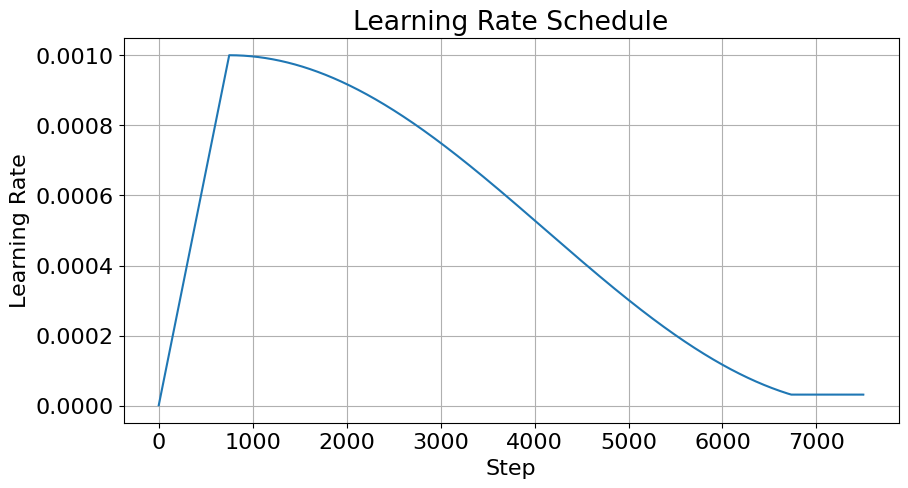

In [11]:
# Implementing a cosine schedule with warmup - found this gives better convergence for my task
# below function creates a learning rate scheduler with linear warmup and cosine decay
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=1e-6):
    
    def lr_lambda(current_step):
        # Warmup phase - critical for stable training at the beginning
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # Cosine decay phase - gently reduces learning rate to prevent overfitting
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        return max(min_lr / optimizer.param_groups[0]['lr'], cosine_decay)
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
# Function to visualize the LR schedule 
def plot_lr_schedule(optimizer, scheduler, steps=100):
    lrs = []
    # Simulating training steps
    for step in range(steps):
        optimizer.step()
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])
    # Plotting the learning rate curve
    plt.figure(figsize=(10, 5))
    plt.plot(lrs)
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    plt.savefig('lr_schedule.png')
    plt.show()
    return lrs
# Setting up a dummy model and optimizer to visualize the LR schedule
dummy_model = nn.Linear(10, 10)
learning_rate = 1e-3
optimizer = optim.AdamW(dummy_model.parameters(), lr=learning_rate, weight_decay=1e-4)
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * 10 
warmup_steps = steps_per_epoch * 1  
cos_scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps, 
    min_lr=1e-6
)
print("Cosine schedule with warmup:")
cos_lrs = plot_lr_schedule(optimizer, cos_scheduler, steps=total_steps)

In [16]:
# Creating the actual contrastive model for training
model = ContrastiveModel(in_channels=train_views1.shape[1]).to(device)
print(model)
# Setting up loss function and optimizer
loss_fn = InfoNCELoss()
learning_rate = 1e-4  # Adjusted based on my experiments for better convergence
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# Setting up the learning rate scheduler
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * 2  # 2 epochs
warmup_steps = steps_per_epoch * 0.5  # 0.5 epoch warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(warmup_steps), 
    num_training_steps=total_steps, 
    min_lr=1e-6
)
epochs = 3
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rates': []
}

Initialized ContrastiveModel with input channels: 125
ContrastiveModel(
  (encoder): ResNet(
    (network): Sequential(
      (0): Conv2d(125, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): ResNetBlock(
        (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (activation1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
        (activation2): ReLU()
        (shortcut_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (shortcut_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (activation3): ReLU()
      )
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.1, inplace=False)
      (6): ResNetBlock(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1,

Epoch 1/3
--------------------
Batch 50/750, Loss: 4.8445, LR: 0.000013
Batch 100/750, Loss: 4.8423, LR: 0.000027
Batch 150/750, Loss: 3.9063, LR: 0.000040
Batch 200/750, Loss: 2.3345, LR: 0.000053
Batch 250/750, Loss: 0.8893, LR: 0.000067
Batch 300/750, Loss: 0.6509, LR: 0.000080
Batch 350/750, Loss: 0.4071, LR: 0.000093
Batch 400/750, Loss: 0.3972, LR: 0.000100
Batch 450/750, Loss: 0.3112, LR: 0.000099
Batch 500/750, Loss: 0.2096, LR: 0.000097
Batch 550/750, Loss: 0.1619, LR: 0.000094
Batch 600/750, Loss: 0.1696, LR: 0.000090
Batch 650/750, Loss: 0.1467, LR: 0.000086
Batch 700/750, Loss: 0.1051, LR: 0.000081
Batch 750/750, Loss: 0.1462, LR: 0.000075
Validating...
Epoch 1/3 - Train Loss: 1.4587, Val Loss: 0.2034
Learning rate: 0.000075
Saving checkpoint...
Epoch 2/3
--------------------
Batch 50/750, Loss: 0.1131, LR: 0.000069
Batch 100/750, Loss: 0.0739, LR: 0.000062
Batch 150/750, Loss: 0.1075, LR: 0.000055
Batch 200/750, Loss: 0.0845, LR: 0.000048
Batch 250/750, Loss: 0.1232, LR: 0

<Axes: >

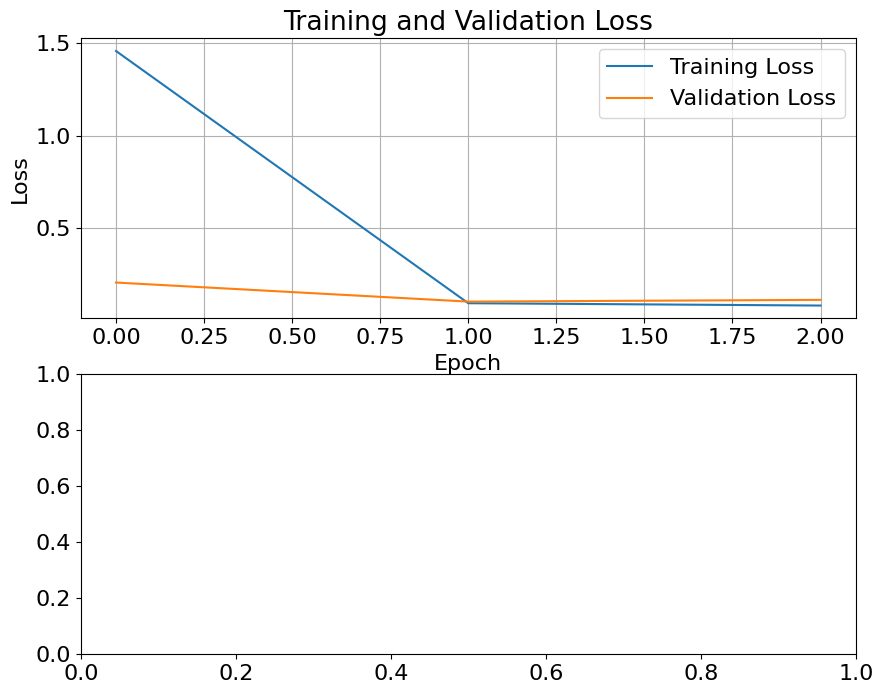

In [17]:
# Training loop
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_steps = 0
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 20)
    for i, (view1, view2) in enumerate(train_loader):
        view1, view2 = view1.to(device), view2.to(device)
        optimizer.zero_grad()
        z1, z2 = model(view1, view2)
        loss = loss_fn(z1, z2, model.temperature)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        train_steps += 1
        # Printing progress at intervals of 50 batches with learning rate
        if (i + 1) % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
    # Calculating average training loss for this epoch    
    avg_train_loss = train_loss / train_steps
    history['train_loss'].append(avg_train_loss)
    # Validation
    model.eval()
    val_loss = 0.0
    val_steps = 0
    print("Validating...")
    with torch.no_grad(): 
        for view1, view2 in val_loader:
            view1, view2 = view1.to(device), view2.to(device)
            z1, z2 = model(view1, view2)
            loss = loss_fn(z1, z2, model.temperature)
            val_loss += loss.item()
            val_steps += 1
    # Calculating average validation loss for this epoch
    avg_val_loss = val_loss / val_steps
    history['val_loss'].append(avg_val_loss)
    # Keeping track of the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    history['learning_rates'].append(current_lr)
    # Printing epoch summary
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Learning rate: {current_lr:.6f}")
    # Saving checkpoint if this is the best model so far
    if epoch == 0 or avg_val_loss < min(history['val_loss'][:-1]):
        print("Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'history': history,
            'input_channels': train_views1.shape[1]  # Saving this for model reconstruction
        }, 'best_contrastive_model.pth')
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)


In [18]:
# Loading the best model
checkpoint = torch.load('/teamspace/studios/this_studio/specific_task_2g/codes/best_contrastive_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Function to extract features using the trained model
def extract_features(data_loader, model):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in data_loader:
            # For feature extraction, we only need one view
            view = batch[0].to(device)
            # Extracting features using only the encoder part of the model
            feature = model.encoder(view)
            features.append(feature.cpu().numpy())
    return np.vstack(features)
# Extract features for downstream tasks - this is what which can be used for other applications
train_features = extract_features(train_loader, model)
val_features = extract_features(val_loader, model)
print(f"Extracted features shapes:")
print(f"Train: {train_features.shape}")
print(f"Validation: {val_features.shape}")
# Saving features
np.save('train_features.npy', train_features)
np.save('val_features.npy', val_features)

Extracted features shapes:
Train: (48000, 512)
Validation: (12000, 512)
